# DCGAN Implementation

Implementation of the (vanilla) Deep Convolutional Generative Adversarial Network defined by <a href="https://arxiv.org/pdf/1511.06434.pdf">Radford, Metz, and Chintala (2016)</a>.  Testing is done on the <a href="https://www.cs.toronto.edu/~kriz/cifar.html">CIFAR-10</a> benchmark image dataset, stored in pickled format in the `data/` directory.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from collections import OrderedDict
import pickle

In [2]:
# Print out the tensors currently allocated
import torch
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(obj.device, type(obj), obj.size())
    except:
        pass

In [3]:
t = torch.cuda.get_device_properties(0).total_memory
c = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = c-a  # free inside cache

print(f"Total CUDA memory: {t / 10**9}")
print(f"Cached CUDA memory: {c/ 10**9}")
print(f"Allocated CUDA memory: {a/ 10**9}")
print(f"Free CUDA memory: {f / 10**9}")

Total CUDA memory: 6.442450944
Cached CUDA memory: 0.0
Allocated CUDA memory: 0.0
Free CUDA memory: 0.0


## Load CIFAR Data

In [4]:
# Helper functions to convert CIFAR-10 to Pytorch Dataset

def enpickle(obj, file):
    import pickle
    with open(file, 'wb') as out_file:
        pickle_dict = pickle.dump(obj, out_file)
    return pickle_dict

def unpickle(file):
    import pickle
    with open(file, 'rb') as in_file:
        pickle_dict = pickle.load(in_file, encoding='bytes')
    return pickle_dict


def read_data(file_name):
    """Given path to CIFAR data batch, returns raw X, y tensors."""
    
    batch_dict = unpickle(file_name)
    X_raw = torch.tensor(batch_dict[b'data'])
    y_raw = torch.tensor(batch_dict[b'labels']).long()
    return X_raw, y_raw


def shape_image(X):
    """Reshapes raw data tensor to nn.module-compatible RGB image"""
    
    # Each row of X_raw contains RGB color channels concatenated in row-major order
    # Need to first split channels into dim 1 on tensor, then shape dim 2/3 into image
    image_size = 32*32
    X = torch.split(X.unsqueeze(dim=1), image_size, dim=2)
    X = torch.cat(X, dim=1)
    X = X.view(-1, 3, 32, 32)   # (N, channels, pixel rows, pixel cols)
    return X


def normalize(X, a=-1, b=1):
    """Normalizes data tensor to [a, b] using min-max scaling."""
    
    data_min = torch.min(X).float().item()
    data_max = torch.max(X).float().item()
    assert a < b, "Rescaled range [a, b] must have a < b"
    
    # First scale to [0, 1], then rescale to [a, b]
    X = (X - data_min) / (data_max - data_min)
    X = (X * (b - a)) + a  
    return X


class CIFARDataset(torch.utils.data.Dataset):
    """Custom Dataset class which preprocesses and stores datasets
       from CIFAR batch files.  Works for CIFAR-10 and CIFAR-100."""
    
    def __init__(self, X=None, y=None):
        self.data = X
        self.labels = y
        
    def load(self, file_list):
        # Get list of (X, y) tuples, concatenate corresponding tensors
        combined_list = [read_data(file_name) for file_name in file_list]
        X_list, y_list = list(zip(*combined_list))
        X = torch.cat(X_list, dim=0)
        y = torch.cat(y_list, dim=0)
        
        self.data = normalize(shape_image(X))
        self.labels = y
        return self
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        # Generates an (X, y) pair at given index
        return self.data[index], self.labels[index]
    
    def cuda(self):
        if torch.cuda.is_available():
            device = torch.device("cuda:0")
            self.data = self.data.to(device)
            self.labels = self.labels.to(device)
            
    def cpu(self):
        self.data = self.data.cpu()
        self.labels = self.labels.cpu()

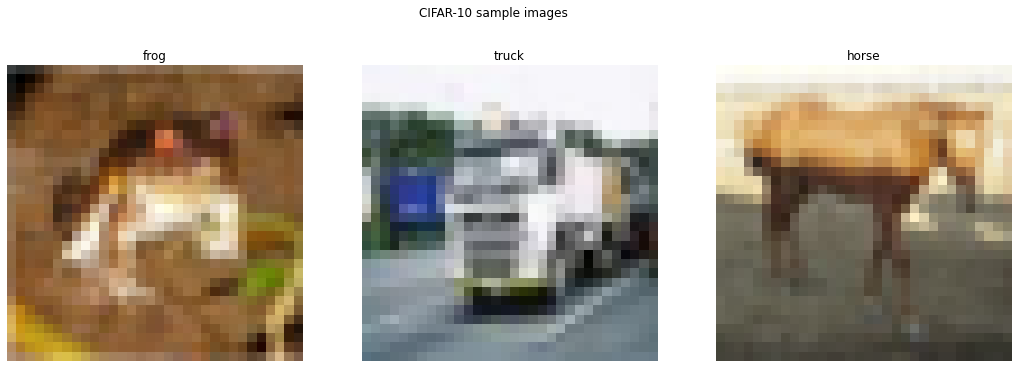

In [5]:
train_set = CIFARDataset().load([f"data/data_batch_{n}" for n in range(1, 6)])
test_set = CIFARDataset().load(["data/test_batch"])
cifar_meta = unpickle("data/batches.meta")

# Visualize a few random examples
def plot_image(x, ax):
    """Helper to scale and plot output from ImageDataset."""
    image = (x.squeeze().permute(1, 2, 0) + 1) / 2
    ax.imshow(image.clone().cpu().detach())
    ax.axis("off")
    
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i in range(3):
    X, y = train_set[i*1000]
    plot_image(X, ax[i])
    ax[i].set_title(cifar_meta[b'label_names'][y.item()].decode('ascii'))
plt.suptitle("CIFAR-10 sample images")
plt.show()

## DCGAN Architecture

In [10]:
# Define architecture for vanilla generator and discriminator
# See also:
# https://gluon.mxnet.io/chapter14_generative-adversarial-networks/dcgan.html
# https://wandb.ai/sairam6087/dcgan/reports/DCGAN-on-CIFAR-10--Vmlldzo5NjMyOQ
# https://github.com/soumith/ganhacks

def conv_block(which_model, conv_args=[], conv_kwargs={'bias': False},
               leak_slope=0.02, batch_norm=True, activation=True):
    """Performs all the operations in a single DCGAN layer in the following order:
       batch normalization -> convolution (optional) -> nonlinearity (optional)
       
       If which == 'gen', does a transpose convolution
       If which == 'dis', does a normal convolution
       Returns a list of functions in order; should unpack and fill in nn.Sequential"""
    
    funcs = []
    
    if which_model == 'gen':
        funcs.append(nn.ConvTranspose2d(*conv_args, **conv_kwargs))
        if batch_norm:
            funcs.append(nn.BatchNorm2d(conv_args[1], affine=False))
        if activation:
            funcs.append(nn.ReLU(inplace=True))
            
    elif which_model == 'dis':
        funcs.append(nn.Conv2d(*conv_args, **conv_kwargs))
        if batch_norm:
            funcs.append(nn.BatchNorm2d(conv_args[1], affine=False))
        if activation:
            funcs.append(nn.LeakyReLU(leak_slope))
            
    else:
        raise ValueError("Argument `which_model` is not a valid value")
        
    # Initialize the weights to match DCGAN paper?
    # Build a list of the three functions in sequence
    return funcs
    

class OldDCGenerator(nn.Module):
    """Deep convolutional generator which maps latent noise vector -> (32,32) RGB-channel image.
       The latent space input z is projected and convolved with many feature maps.
       Subsequent layers use only fractional-strided convolutions (no pooling).
       All hidden layers use ReLU activation, and output layer uses tanh."""
    
    def __init__(self, z_len=100):
        
        super(OldDCGenerator, self).__init__()
        self.z_len = z_len
        
        self.in_layer = nn.Linear(z_len, 128 * 4 * 4)
        
        # Choose kernel_size, stride, padding to double height/width for each layer
        self.conv_layers = nn.Sequential(
            #*conv_block('gen', [z_len, 128, 4, 1, 0]),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            *conv_block('gen', [128, 128, 4, 2, 1]),
            *conv_block('gen', [128, 128, 4, 2, 1]),
            *conv_block('gen', [128, 3, 4, 2, 1], batch_norm=False, activation=False),
            nn.Tanh()
        )
    
    def forward(self, z):
        # Reshape z as 4d tensor
        z = self.in_layer(z).view(-1, 128, 4, 4)
        return self.conv_layers(z)


class OldDCDiscriminator(nn.Module):
    """Deep convolutional discriminator which maps (32,32) RGB-channel image -> [0, 1].
       The image is passed through several convolutional layers (again, no pooling).
       All hidden layers use LeakyReLU activation, and output layer uses sigmoid."""
    
    def __init__(self, leak_slope=0.02):
        
        super(OldDCDiscriminator, self).__init__()
        
        # Just reverse the convolutional layers from the Generator
        self.conv_layers = nn.Sequential(
            *conv_block('dis', [3, 128, 4, 2, 1], batch_norm=False),
            *conv_block('dis', [128, 128, 4, 2, 1]),
            *conv_block('dis', [128, 128, 4, 2, 1])
        )
        
        self.out_layer = nn.Sequential(
            nn.Linear(128 * 4 * 4, 100),
            nn.LeakyReLU(leak_slope),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        # Reshape discriminator output by flattening, then feed into sigmoid activation
        x = x.view(-1, torch.prod(torch.tensor(x.shape[1:])))
        return self.out_layer(x)

In [11]:
class DCGenerator(nn.Module):
    """Deep convolutional generator which maps latent noise vector -> (32,32) RGB-channel image.
       The latent space input z is projected and convolved with many feature maps.
       Subsequent layers use only fractional-strided convolutions (no pooling).
       All hidden layers use ReLU activation, and output layer uses tanh."""
    
    def __init__(self, z_len=100):
        
        super(DCGenerator, self).__init__()
        self.z_len = z_len
        
        # Choose kernel_size, stride, padding to double height/width for each layer
        self.conv_layers = nn.Sequential(
            *conv_block('gen', [z_len, 512, 4, 1, 0]),
            *conv_block('gen', [512, 256, 4, 2, 1]),
            *conv_block('gen', [256, 128, 4, 2, 1]),
            *conv_block('gen', [128, 3, 4, 2, 1], batch_norm=False, activation=False),
            nn.Tanh()
        )
    
    def forward(self, z):
        # Reshape z as 4d tensor, with latent code along channel dimension
        z = z.view(z.shape[0], self.z_len, 1, 1)
        return self.conv_layers(z)


class DCDiscriminator(nn.Module):
    """Deep convolutional discriminator which maps (32,32) RGB-channel image -> [0, 1].
       The image is passed through several convolutional layers (again, no pooling).
       All hidden layers use LeakyReLU activation, and output layer uses sigmoid."""
    
    def __init__(self, leak_slope=0.02):
        
        super(DCDiscriminator, self).__init__()
        
        # Just reverse the convolutional layers from the Generator
        self.conv_layers = nn.Sequential(
            *conv_block('dis', [3, 64, 4, 2, 1], batch_norm=False),
            *conv_block('dis', [64, 128, 4, 2, 1]),
            *conv_block('dis', [128, 256, 4, 2, 1]),
            *conv_block('dis', [256, 1, 4, 1, 0], batch_norm=False, activation=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.conv_layers(x).squeeze().unsqueeze(1)

In [12]:
# Test that the generator/discriminator give the expected shapes
gen = DCGenerator()
dis = DCDiscriminator()
z_test = torch.randn(5, 100)

print(gen(z_test).shape)
print(dis(gen(z_test)).shape)

torch.Size([5, 3, 32, 32])
torch.Size([5, 1])


## Evaluation of Generated Images

The main metric we use to evaluate how closely the generated images reflect the training set is the *Frechet inception distance.*  This is a distance metric which compares statistics of samples drawn from the $P_{model}$ and $P_{real}$ distributions.  For corresponding sets of samples $\{x^{(1)}_{model}, ..., x^{(N)}_{model}\}$ and $\{x^{(1)}_{real}, ..., x^{(N)}_{real}\}$, each $x^{(i)}$ is projected into a 2048-dimensional feature space by running a forward pass through an <a href="https://arxiv.org/pdf/1512.00567.pdf">Inception v3</a> convolutional net pre-trained on the ImageNet dataset, which here is acting essentially as an autoencoder.  This network maps tensors of size $(N, 3, 299, 299) \to (N, 1, 1, 100)$.  So the CIFAR-10 images have to first be zero-padded to the $(299, 299)$ ImageNet size, and then we have to slightly modify the model to output the penultimate layer of size $(N, 1, 1, 2048)$.

These embedded vectors are assumed to obey some multivariate Gaussian distribution, such that $x^{(i)}_{emb, model} \overset{\text{iid}}{\sim} \mathcal{N}_{2048}(\mu_1, \Sigma_1)$ and $x^{(i)}_{emb, real} \overset{\text{iid}}{\sim} \mathcal{N}_{2048}(\mu_2, \Sigma_2)$.  Then, the FID is the statistical Frechet distance between these two vectors:
$$ FID = ||\mu_1 - \mu_2||^2_2 + tr[\Sigma_1 + \Sigma_2 - 2(\Sigma_1 \Sigma_2)^{1/2}] $$

In [41]:
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
from torch.nn.modules.upsampling import Upsample
import pickle

iv3 = inception_v3(pretrained=True, aux_logits=False)
# Remove the final layer and dropout layer from the forward pass
iv3.dropout = nn.Identity()
iv3.fc = nn.Identity()
# Add a non-weighted upsampling layer to make this compatible to CIFAR-10
upsample = Upsample(scale_factor=299/32)

# FID runs considerably faster if this is loaded on GPU
if torch.cuda.is_available():
    iv3.cuda()

In [42]:
def calc_iv3_stats(dataset, batch_size=100):
    """Encodes images in CIFARDataset as dense feature vectors via partial Inception v3
       network, and returns estimated mean and covariance in this embedding space.
       
       It really helps to run this on a GPU, if possible."""
    
    # Pick some random layer of Inception v3 to check device
    device = iv3.Conv2d_1a_3x3.conv.weight.device
    embeds = np.zeros((len(dataset), 2048))
    
    loader = torch.utils.data.DataLoader(dataset, batch_size)
        
    # Run the encoding in batches to avoid memory overload
    for batch_num, (samples, _) in enumerate(loader):
        # Necessary to stop gradients from accumulating in iv3 forward passes
        with torch.no_grad():
            samples = samples.to(device)
            # (N, 3, 32, 32) -> (N, 2048)
            embedded = iv3(upsample(samples)).detach().cpu()
            embeds[batch_num*batch_size:(batch_num+1)*batch_size, :] = embedded
    
    mu = np.mean(embeds, axis=0)
    cov = np.cov(embeds, rowvar=False)
    return mu, cov


def calc_fid(fake_mu, fake_cov, real_mu, real_cov):
    """Calculates the Frechet Inception Distance (FID) between two empirical distributions.
       Each `*_mu` should be (2048,) vector
       Each `*_cov` should be (2048, 2048) matrix as returned by `calc_iv3_stats`."""    

    mu_diff = fake_mu - real_mu
    # geometric mean of cov mxs; may be complex, so take real part
    cov_geom = sqrtm(fake_cov @ real_cov).real
    
    return (mu_diff @ mu_diff +
            np.trace(fake_cov) + np.trace(real_cov) - 2 * np.trace(cov_geom))


def eval_gen(gen, real_mu, real_cov, num_samples=100, num_folds=1, use_cuda=True):
    """Helper function which evaluates generator's ability to create samples.
       Simulates `num_folds` datasets of size `num_samples`, calculates FID between
       the fake and some real dataset, and returns the results across all folds."""
    
    device = "cuda:0" if use_cuda and torch.cuda.is_available() else "cpu"
    gen.to(device)
    
    fid = []
    for i in range(num_folds):
        with torch.no_grad():
            z_test = torch.randn(num_samples, gen.z_len).to(device)
            gen_set = CIFARDataset(gen(z_test), torch.empty(num_samples))
            gen_mu, gen_cov = calc_iv3_stats(gen_set)
            
            fid.append(calc_fid(gen_mu, gen_cov, real_mu, real_cov))
            print(f"Fold {i+1}: {fid[-1]}")
    
    return fid

In [34]:
# Generate the stats for the training and testing sets in advance
# This can be very time consuming, but only needs to be done once
#%time train_mu, train_cov = calc_iv3_stats(train_set)
#%time test_mu, test_cov = calc_iv3_stats(test_set)

# Store these statistics in a dictionary for later use
#cifar_stats = {"train_stats": (train_mu, train_cov),
               #"test_stats": (test_mu, test_cov)}
#enpickle(cifar_stats, "models/cifar_stats")

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Wall time: 4min 57s
Wall time: 59.8 s


In [43]:
# General format for evaluating generator
cifar_stats = unpickle("models/cifar_stats")
%time eval_gen(gen, *cifar_stats["train_stats"])

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Fold 1: 117.26952249742261
Wall time: 5.13 s


[117.26952249742261]

## DCGAN Training

The training is done using the minimax game described in the original GAN paper by <a href="https://arxiv.org/pdf/1406.2661.pdf">Goodfellow, et al (2014)</a>.  The choice of optimizer and batch size are specific to the DCGAN architecture.

In [46]:
# Functions to train built models and evaluate convergence

def jensen_shannon(which_model, device):
    """Returns a function to compute an empirical estimate of the Jensen-Shannon
       divergence between the true data-generating distribution P_real and
       the generated distribution P_model over parallel batches x_real and x_model.
       
       This metric is optimized by a minimax operation, first maximizing over the
       discriminator weights, then minimizing over the generator weights.
       
       Returns:
       - if which_model = 'dis': returns function (D(x_model), D(x_real)) -> scalar
       - if which_model = 'gen': returns function (D(x_model)) -> scalar
         Both functions are returned in the form of minimization problems."""
    
    bce = nn.BCELoss()
    
    # Functions to compute respective discriminator labels
    # Consider label smoothing: draw some value near 0 or 1
    fake = lambda d: 0.1 * torch.ones(d.size()).to(device)
    real = lambda d: 0.9 * torch.ones(d.size()).to(device)
    
    if which_model == 'dis':
        #return lambda dis_model, dis_real: \
            #-torch.mean(torch.log(dis_real) + torch.log(1 - dis_model))  
        model_loss = lambda d_model: bce(d_model, fake(d_model))
        real_loss = lambda d_real: bce(d_real, real(d_real))
        return lambda d_model, d_real: model_loss(d_model) + real_loss(d_real)
        
    elif which_model == 'gen':
        # If generated samples are rejected easily, log(1 - D(x_model)) saturates
        # (stays close to 0), so use an approximation to improve early training
        #return lambda dis_model: \
            #-torch.mean(torch.log(dis_model))
        return lambda d_model: bce(d_model, real(d_model))
    
    else:
        raise ValueError("Argument `which_model` is not a valid value")

        
def train_DCGAN(gen, dis, train_set, test_set,
                num_epochs=100, dg_ratio=1, batch_size=128,
                use_cuda=True, print_every=1, train_summ=None, calc_fid=True):
    """Simultaneously trains generator and discriminator using minimax optimization of
       Jensen-Shannon divergence between discriminator performance on x_real vs. x_model.
       Uses ADAM optimizer for both networks, using params defined in DCGAN paper.
       Latent codes Z are drawn from a uniform prior.
       
       Parameters
       - num_epochs: the number of training epochs over the dataset
       - dg_ratio: the ratio of discriminator batches to generator batches
       - batch_size: the train_set batch size passed into discriminator
                     (for each real batch, an equal-sized batch is generated by generator)
    """
    
    # Move to GPU if possible; batches get moved as needed to save on memory
    device = "cuda:0" if use_cuda and torch.cuda.is_available() else "cpu"
    
    criterion_dis = jensen_shannon("dis", device)
    criterion_gen = jensen_shannon("gen", device)
    optimizer_dis = torch.optim.Adam(dis.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_gen = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    # Initialize a dictionary summarizing training, if one not provided
    if train_summ is None:
        train_summ = {'loss_dis': [],  # one per batch
                      'loss_gen': [],  # one per batch
                      'fid': [],       # one per epoch
                      'num_epochs': num_epochs}
    else: train_summ['num_epochs'] += num_epochs
    
    loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
    # Keep a global count of how many discriminator steps happen per generator step
    # because dg_ratio may not divide evenly into batch_size
    dis_count = 0
    for epoch in range(num_epochs):
        #print(f"EPOCH {epoch+1}")
        
        for X, y in loader:
            z = torch.randn((X.shape[0], gen.z_len)).to(device)
            X = X.clone().to(device, non_blocking=True)
            
            # Discriminator trains each batch
            optimizer_dis.zero_grad()
            loss_dis = criterion_dis(dis(gen(z)), dis(X))
            loss_dis.backward()
            optimizer_dis.step()
            dis_count += 1
            train_summ['loss_dis'].append(loss_dis.detach().cpu().item())
            
            # Generator trains if enough discriminator passes have gone through
            if dis_count >= dg_ratio:
                #z = torch.rand((batch_size, gen.z_len)).to(device)
                optimizer_gen.zero_grad()
                loss_gen = criterion_gen(dis(gen(z)))
                loss_gen.backward()
                optimizer_gen.step()
                dis_count = 0
                train_summ['loss_gen'].append(loss_gen.detach().cpu().item())
         
        # Calculate the FID for generator
        train_summ['fid'].append(eval_gen(gen, *cifar_stats["train_stats"]))
        
        # Evaluate how the model is performing on test set after a full epoch
        if (epoch+1) % print_every == 0:
            print(f"- EPOCH {epoch+1}:" +
                  f"\n  discriminator loss = {loss_dis}" +
                  f"\n      generator loss = {loss_gen}" +
                  "\n----------------------------------")
    
    return train_summ

In [70]:
# Functions to plot training results

def plot_train_summaries(train_summs):
    """Produces plots that summarize and compare training across models.
       Input should be a dictionary of the form:
       {model_name: {loss_dis: [...],
                     loss_gen: [...],
                     fid: [...],
                     num_epochs: ### } (dict returned by train_*) }"""
    
    # Produce a unique training plot for every model
    for model_name in train_summs:
        train_summ = train_summs[model_name]
        epochs = np.linspace(0, train_summ['num_epochs'], len(train_summ['loss_dis']))
        
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(epochs, train_summ['loss_dis'], label="discriminator")
        ax.plot(epochs, train_summ['loss_gen'], label="generator")
        ax.legend()
        ax.set_title(f"Training Curves for {model_name}")
        ax.set_xlabel("epoch number")
        ax.set_ylabel("loss")
        plt.show()
    
    # Produce one plot for the FID across models
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title("Frechet Inception Distance Across Models")
    ax.set_xlabel("epoch number")
    ax.set_ylabel("FID")
    for model_name in train_summs:
        if len(train_summs[model_name]["fid"]) > 0:
            ax.plot(range(1, train_summs[model_name]["num_epochs"]+1),
                    train_summs[model_name]["fid"],
                    label=model_name,
                    linestyle='dashdot')
    ax.legend()
            

def plot_generator_samples(gen, width=4, height=4, use_cuda=True, title=""):
    """Produces collage of images randomly generated by `gen.`
       Arranges images in grid of shape (`height`, `width`)."""
    
    device = "cuda:0" if use_cuda and torch.cuda.is_available() else "cpu"
    gen.to(device)
    
    fig, ax = plt.subplots(height, width, figsize=(2*width, 2*height + 2))
    
    with torch.no_grad():
        z_test = torch.randn(width * height, gen.z_len).to(device)
        gen_z_test = gen(z_test)

        for i in range(height):
            for j in range(width):
                plot_image(gen_z_test[i*width + j], ax[i][j])
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

In [54]:
gen = DCGenerator().cuda()
dis = DCDiscriminator().cuda()
train_set = CIFARDataset().load([f"data/data_batch_{n}" for n in range(1, 2)])
test_set = CIFARDataset().load(["data/test_batch"])

In [72]:
%time train_summ = train_DCGAN(gen, dis, train_set, test_set, dg_ratio=1, num_epochs=5)

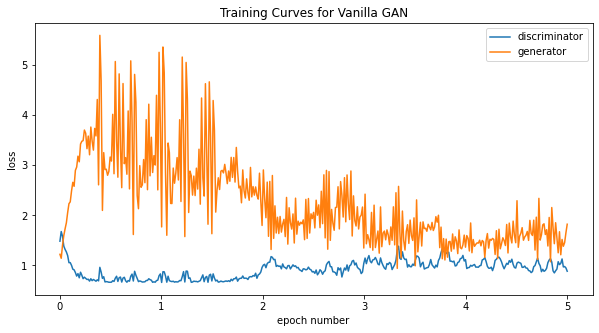

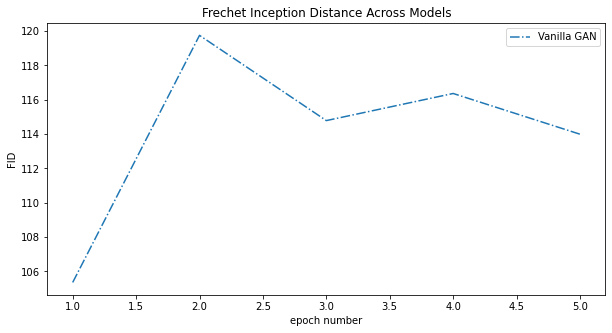

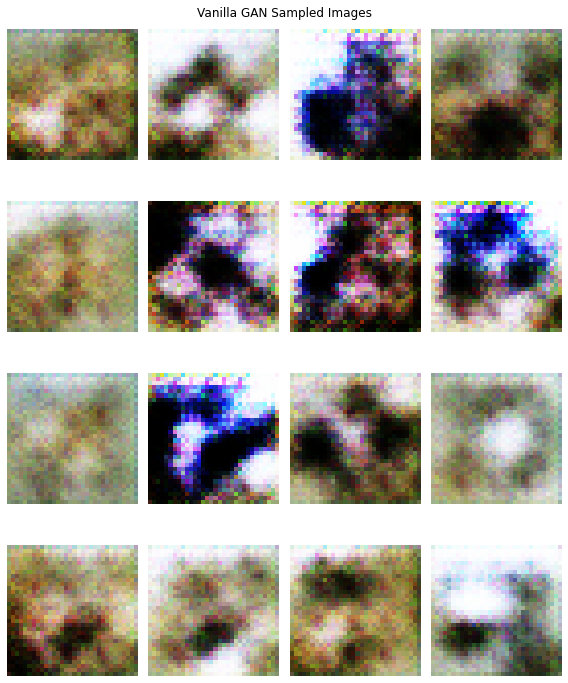

In [73]:
plot_train_summaries({"Vanilla GAN": train_summ})
plot_generator_samples(gen, title="Vanilla GAN Sampled Images")

In [74]:
# Can store trained models like this

#torch.save(gen, "models/online_gen")
#torch.save(dis, "models/online_dis")
#gen = torch.load("models/online_gen")
#dis = torch.load("models/online_dis")

## Conditional DCGANs

As an attempt to stabilize the model, we implement a training procedure for the conditional version of the DCGAN architecture above, based on the original <a href="https://arxiv.org/pdf/1411.1784.pdf">Conditional GAN</a> paper and <a href="https://arxiv.org/pdf/1606.03498.pdf">Salimans, et al (2016)</a>.  Whereas the vanilla GAN optimizes the objective function
$$
\min_G \max_D V(G, D)
    = \mathbb{E}_{\mathbf{x} \sim p_{real}(\mathbf{x})} \log D(\mathbf{x})
    + \mathbb{E}_{\mathbf{z} \sim p_{model}(\mathbf{x})} \log (1-D(G(\mathbf{z})))
$$
the conditional GAN simply adjusts this to
$$
\min_G \max_D V(G, D)
    = \mathbb{E}_{\mathbf{x} \sim p_{real}(\mathbf{x})} \log D(\mathbf{x} | \mathbf{y})
    + \mathbb{E}_{\mathbf{z} \sim p_{model}(\mathbf{x})} \log (1-D(G(\mathbf{z} | \mathbf{y})))
$$
where $\mathbf{y}$ is some auxiliary vector (in this case, the CIFAR-10 labels).

This can be accomplished by simply concatenating the auxiliary vector $\mathbf{y}$ with a dense encoding in both the generator (at the input layer) and the discriminator (at the output layer).  The loss function Below is essentially a generalized version of the code above which allows for labels.  Setting `y_len = 0` and `num_classes = 1` recovers the unconditional model.

In [ ]:
# Conditional generalizations of some of the architecture/training functions
# http://cs231n.stanford.edu/reports/2015/pdfs/jgauthie_final_report.pdf

class CDCGenerator(DCGenerator):
    """CONDITIONAL deep convolutional generator which maps
       latent noise vector z, auxiliary y -> (32,32) RGB-channel image.
       The latent space input z is projected and convolved with many feature maps.
       Subsequent layers use only fractional-strided convolutions (no pooling)."""
    
    def __init__(self, z_len=100, y_len=10, code_len=5):
        super().__init__(z_len)
        self.y_len = y_len
        self.y_encode = nn.Linear(y_len, code_len)
        # Modify the parent architecture to accept larger input
        self.in_layer = nn.Linear(z_len + code_len, self.in_layer.out_features)
        
    def forward(self, z, y):
        # Encode y to avoid sparse representation
        y_code = self.y_encode(y)
        # Concatenate z and y, reshape as 4d tensor
        z = torch.cat([z, y_code], dim=1)
        z = self.in_layer(z).view(-1, 128, 4, 4)
        return self.conv_layers(z)
    

class CDCDiscriminator(DCDiscriminator):
    """CONDITIONAL deep convolutional discriminator which maps
       (32,32) RGB-channel image, auxiliary y -> [0, 1].
       The image is passed through several convolutional layers (again, no pooling).
       All hidden layers use LeakyReLU activation, and output layer uses sigmoid."""
    
    def __init__(self, leak_slope=0.02, y_len=10, code_len=5):
        super().__init__(leak_slope)
        self.y_len = y_len
        self.y_encode = nn.Linear(y_len, code_len)
        # Modify the parent architecture to allow concatenating in final layer
        self.out_layer[2] = nn.Linear(self.out_layer[2].in_features + code_len, 1)
        
    def forward(self, x, y):
        # Encode y to avoid sparse representation
        y_code = self.y_encode(y)
        x = self.conv_layers(x)
        # Reshape discriminator output by flattening
        x = x.view(-1, torch.prod(torch.tensor(x.shape[1:])))
        x = self.out_layer[:2](x)
        # Concatenate y at the final stage, before sigmoid activation
        x = torch.cat([x, y_code], dim=1)
        return self.out_layer[2:](x)


def onehot(y, num_classes, as_float=True):
    """Returns a one-hot encoding version of 1d vector y."""
    
    y_onehot = torch.zeros(len(y), num_classes, dtype=torch.long)
    y_onehot[range(len(y)), y] = 1
    if as_float:
        y_onehot = y_onehot.float()
    return y_onehot

    
def cond_jensen_shannon(which_model, device):
    """Returns a function to compute an empirical estimate of the Jensen-Shannon
       divergence between the true data-generating distribution P_real and
       the generated distribution P_model over parallel batches x_real and x_model,
       CONDITIONED on auxiliary vector y.
       
       This metric is optimized by a minimax operation, first maximizing over the
       discriminator weights, then minimizing over the generator weights.
       
       Returns:
       - if which_model = 'dis': returns function (D(x_model), D(x_real), y) -> scalar
       - if which_model = 'gen': returns function (D(x_model), y) -> scalar
         Both functions are returned in the form of minimization problems.
       - if which_model = 'full': returns non-negative version of 'dis' function.
         Use this version to calculate divergence after an epoch."""
    
    ce = nn.CrossEntropyLoss()
    
    # Functions to compute respective discriminator labels
    fake = lambda d: torch.zeros(d.size(), dtype=torch.long).to(device)
    
    if which_model == 'dis':
        #return lambda dis_model, dis_real: \
            #-torch.mean(torch.log(dis_real) + torch.log(1 - dis_model))  
        model_loss = lambda d_model, y: ce(d_model, 0 * y)
        real_loss = lambda d_real, y: ce(d_real, y)
        return lambda d_model, d_real, y: model_loss(d_model, y) + real_loss(d_real, y)
        
    elif which_model == 'gen':
        # If generated samples are rejected easily, log(1 - D(x_model)) saturates
        # (stays close to 0), so use an approximation to improve early training
        #return lambda dis_model: \
            #-torch.mean(torch.log(dis_model))
        return lambda d_model, y: ce(d_model, y)
   
    else:
        raise ValueError("Argument `which_model` is not a valid value")
        

def train_CDCGAN(gen, dis, train_set, test_set, num_classes=1,
                num_epochs=100, dg_ratio=1, batch_size=128,
                use_cuda=True, print_every=1):
    """Simultaneously trains generator and discriminator using minimax optimization of
       Jensen-Shannon divergence between discriminator performance on x_real vs. x_model.
       Uses ADAM optimizer for both networks, using params defined in DCGAN paper.
       Latent codes Z are drawn from a uniform prior.
       
       Parameters
       - num_epochs: the number of training epochs over the dataset
       - dg_ratio: the ratio of discriminator batches to generator batches
       - batch_size: the train_set batch size passed into discriminator
                     (for each real batch, an equal-sized batch is generated by generator)
    """
    
    # Move to GPU if possible; batches get moved as needed to save on memory
    device = "cuda:0" if use_cuda and torch.cuda.is_available() else "cpu"
    
    criterion_dis = jensen_shannon("dis", device)
    criterion_gen = jensen_shannon("gen", device)
    optimizer_dis = torch.optim.Adam(dis.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_gen = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
    # Keep a global count of how many discriminator steps happen per generator step
    # because dg_ratio may not divide evenly into batch_size
    dis_count = 0
    for epoch in range(num_epochs):
        #print(f"EPOCH {epoch+1}")
        
        for X, y in loader:
            z = torch.randn((X.shape[0], gen.z_len)).to(device)
            # Sample random y values from distribution of labels
            y_rand = np.random.choice(num_classes, size=X.shape[0])
            y_rand_onehot = onehot(y_rand, num_classes).float().to(device)
            
            X = X.clone().to(device, non_blocking=True)
            y = y.clone().to(device, non_blocking=True)
            y_onehot = onehot(y, num_classes).float().to(device)
            
            # Discriminator trains each batch
            optimizer_dis.zero_grad()
            loss_dis = criterion_dis(dis(gen(z, y_rand_onehot), y_rand_onehot),
                                     dis(X, y_onehot))
            loss_dis.backward()
            optimizer_dis.step()
            dis_count += 1
            
            # Generator trains if enough discriminator passes have gone through
            if dis_count >= dg_ratio:
                z = torch.randn((X.shape[0], gen.z_len)).to(device)
                
                optimizer_gen.zero_grad()
                loss_gen = criterion_gen(dis(gen(z, y_rand_onehot), y_rand_onehot))
                loss_gen.backward()
                optimizer_gen.step()
                dis_count = 0
 
        # Evaluate how the model is performing on test set after a full epoch
        if (epoch+1) % print_every == 0:
            print(f"- EPOCH {epoch+1}:" +
                  f"\n  discriminator loss = {loss_dis}" +
                  f"\n      generator loss = {loss_gen}" +
                  "\n----------------------------------")

In [ ]:
cgen = CDCGenerator(y_len=len(label_set))
cdis = CDCDiscriminator(y_len=len(label_set))

z_test = torch.randn(15, cgen.z_len)
y_rand = np.random.choice(len(label_set), size=15)
X, y = train_set[:15]
y_onehot = onehot(y, cgen.y_len)

cdis(cgen(z_test, y_onehot), y_onehot).shape

In [ ]:
train_set = CIFARDataset().load([f"data/data_batch_{n}" for n in range(1, 2)])
test_set = CIFARDataset().load(["data/test_batch"])
label_set = [label.decode('ascii') for label in cifar_meta[b'label_names']]

cgen = CDCGenerator(y_len=len(label_set)).cuda()
cdis = CDCDiscriminator(y_len=len(label_set)).cuda()

In [ ]:
%time train_CDCGAN(cgen, cdis, train_set, test_set, num_classes=len(label_set), \
                   dg_ratio=1, num_epochs=50)

In [ ]:
z_test = torch.randn(1, cgen.z_len).cuda()
X, y = train_set[:1]
y_onehot = onehot(y, cgen.y_len).cuda()
fake_X = cgen(z_test, y_onehot)
fake_y = torch.randperm(cgen.y_len)[0]

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
plot_image(fake_X[0], ax[0])
plot_image(X[0], ax[1])
ax[0].set_title(f"{label_set[fake_y.item()]}?")
ax[1].set_title(label_set[y[0].item()])

print(f"Possible labels: {[label.decode('ascii') for label in cifar_meta[b'label_names']]}\n")